In [1]:
# Partial Fitting. Alternative xgboost would be a best choose
#    'Perceptron': Perceptron(),
    #'NB Multinomial': MultinomialNB(alpha=0.01),
    #'Passive-Aggressive': PassiveAggressiveClassifier() -- slow to train

In [7]:
from helper import (load_data, token, show_diagram,
                      show_most_informative_features)

In [8]:
## Long process timing that %time does not work
from datetime import datetime
import humanfriendly


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight') # plt.style.available

In [10]:
from sklearn.externals import joblib
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import HashingVectorizer

#### Why HashingVectorizer? TfidfVectorizer, CountVectorizer + TfidfTransformer

In [11]:

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [12]:
stops = joblib.load('../stops.pkl')

Loading data ...
Droping 10 rows with features lenght of less than 2
Droping 3 as rating and setting 1-2 as negative(0), 4-5 as positive(1))
{1: 460527, 0: 127232} 

Data loading completed
{1: 460527, 0: 127232} 

Execution Time: 4 seconds


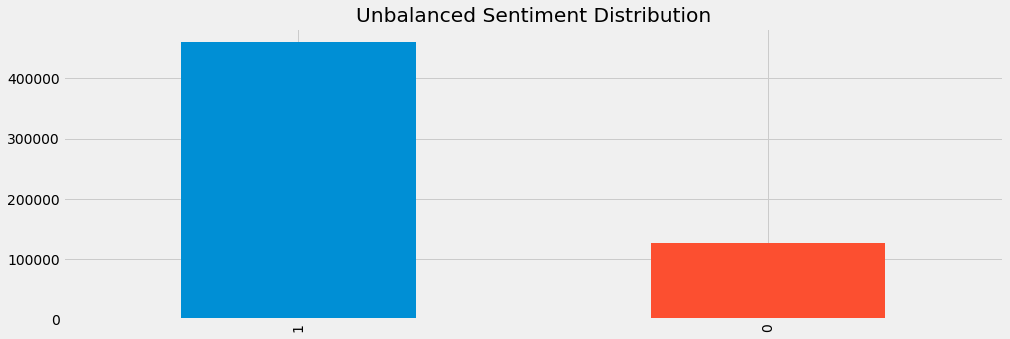

In [19]:
df = load_data('../sentiment_data', balanced=False) # Using unbalance Data

In [129]:
hash_para = dict(decode_error='ignore', n_features=2**18, tokenizer=token,
                stop_words=stops, ngram_range=(1,3), alternate_sign=False)
clf_prep = HashingVectorizer(**hash_para)

In [131]:
clf_prep = HashingVectorizer(**hash_para)
clf = SGDClassifier(loss='log', random_state=1, max_iter=1)

In [148]:
def sgd_model(X,y=None,method=None):
    if method == 'train':
        print('Training Model...')
        u = datetime.now()
        clf.partial_fit(clf_prep.transform(X), y,classes=np.unique(y))
        v = datetime.now()
        delta = v-u
        print('Training took: {}'.format(
            humanfriendly.format_timespan(delta.seconds)))

        return clf
    if method == 'score':
        return clf.score(clf_prep.transform(X),y)
    
    if method == 'predict':
        return clf.predict(clf_prep.transform(X))
    else:
        return clf.predict_proba(clf_prep.transform(X))
        
   

In [ ]:
clf = sgd_model(X_train,y_train,'train')

Training Model...


In [150]:
score = sgd_model(X_test,y_test,'score')

In [151]:
score

0.921338641622431